**<font color = black size=6>实验十一：支持向量机</font>**

In [539]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import cvxopt
from cvxopt import matrix
from cvxopt import solvers

**<font color = blue size=4>第一部分:函数介绍</font>**

二次规划问题是形式如下的一类最优化问题：
$$
\begin{align}
\min_x \quad  &\frac{1}{2}x^TPx+q^Tx \\
s.t. \quad  &Gx\leq h \\
      &Ax=b
\end{align}
$$
对于这一类问题可以使用[cvxopt](https://cvxopt.org/userguide/coneprog.html#quadratic-programming)库的solvers.qp()函数进行求解。

以下是一个例子（参考[Solving a quadratic program](https://cvxopt.org/examples/tutorial/qp.html)）:
$$
\begin{align}
\min_x \quad  &2x_1^2+x_2^2+x_1x_2+x_1+x_2 \\
s.t. \quad  &x_1\geq 0 \\
      &x_2\geq 0 \\
      &x_1+x_2=1
\end{align}
$$
为了使用solvers.qp()函数，我们需要知道在该二次规划问题中的$P,q,G,h,A,b$矩阵分别是什么。
在该优化问题中，

* $P:=\begin{bmatrix}
    4 & 1 \\ 1 & 2
   \end{bmatrix}$,
* $q:=\begin{bmatrix}
    1 \\ 1
   \end{bmatrix}$,
* $G:=\begin{bmatrix}
    -1 & 0 \\ 0 & -1
   \end{bmatrix}$,
* $h:=\begin{bmatrix}
    0 \\ 0
   \end{bmatrix}$,
* $A:=\begin{bmatrix}
    1 & 1
   \end{bmatrix}$,
* $b:=\begin{bmatrix}
    1
   \end{bmatrix}$,
   
把这些参数送入solvers.qp()函数中即可求出解。

In [540]:
# Tips1: cvxopt库中的matrix只接受double类型的数据
# Tips2: matrix使用列表作为参数创建矩阵和numpy.array使用列表作为参数创建矩阵是不同的
# print(matrix([[1.0, 1.0]]))
# print(np.array([[1.0, 1.0]]))
# print(matrix(np.array([[1.0, 1.0]])))

P = 2*matrix([ [2, .5], [.5, 1] ])
q = matrix([1.0,1.0])
G = matrix([[-1.0,0.0],[0.0,-1.0]])
h = matrix([0.0,0.0])
A = matrix([1.0, 1.0], (1,2))
b = matrix(1.0)
sol=solvers.qp(P, q, G, h, A, b)
print(sol['x'])

     pcost       dcost       gap    pres   dres
 0:  1.8889e+00  7.7778e-01  1e+00  2e-16  2e+00
 1:  1.8769e+00  1.8320e+00  4e-02  1e-16  6e-02
 2:  1.8750e+00  1.8739e+00  1e-03  2e-16  5e-04
 3:  1.8750e+00  1.8750e+00  1e-05  1e-16  5e-06
 4:  1.8750e+00  1.8750e+00  1e-07  3e-16  5e-08
Optimal solution found.
[ 2.50e-01]
[ 7.50e-01]



**<font color = blue size=4>第二部分:实验任务</font>**

1.线性可分支持向量机与硬间隔最大化

<span style="color:purple">1)  
这一部分使用的数据集'dataset1.csv'是一个线性可分的数据集。每个数据样本包含两个特征$x_1$, $x_2$以及一个标签$y\in\{1,-1\}$。  
首先，请读入数据集'dataset1.csv',把数据类型都转换成np.double类型，并画出数据集的散点图，给正样本（y为+1）和负样本（y为-1）分别标上不同的颜色。</span>

Index(['x1', 'x2', 'y'], dtype='object')


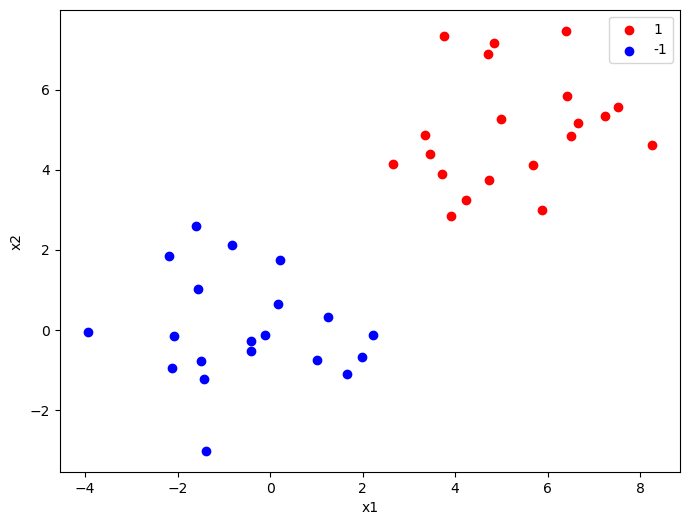

In [541]:
# ---- Your code here ----

train_df_ds1 = pd.read_csv('./dataset1.csv')

print(train_df_ds1.columns)

train_df_ds1 = train_df_ds1.astype(np.double)
y_label_1 = train_df_ds1[train_df_ds1['y']==1]
y_label_neg1 = train_df_ds1[train_df_ds1['y']==-1]

plt.figure(figsize=(8,6))
plt.scatter(y_label_1['x1'],y_label_1['x2'],color='r',label='1')
plt.scatter(y_label_neg1['x1'],y_label_neg1['x2'],color='b',label='-1')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()

<span style="color:purple">2)  
求对偶问题的最优解$\lambda^*$  
在数据线性可分的场景中，为了找到一个能最好地划分正样本和负样本的超平面$\pmb{\omega}^T \pmb{x}+b=0$，我们需要求解下面这个主问题。
\begin{align}
\min_{\pmb{\omega},b}\quad &\frac12 ||\pmb{\omega}||^2\\
s.t.\quad &y_i(\pmb{\omega}^T \pmb{x}_i+b)\ge 1,i=1,...,m
\end{align}
</span>

<span style="color:purple">对应地，即求解如下对偶问题（参考课件）：</span>
$$
\begin{align}
\min_\lambda \quad  &\frac{1}{2}\sum_{i=1}^m\sum_{j=1}^m\lambda_i\lambda_jy_iy_j\pmb{x}_i^T\pmb{x}_j-\sum_{i=1}^m\lambda_i \\
s.t. \quad  &\sum_{i=1}^m\lambda_iy_i=0 \\
      &\pmb{\lambda}\geq \pmb{0}
\end{align}
$$

这个优化问题是一个二次规划问题，可以写成如下形式：
$$
\begin{align}
\min_{\pmb{\lambda}} \quad  &\frac{1}{2}\lambda^TP\lambda+q^T\lambda \\
s.t. \quad  &G\lambda\leq h \\
      &A\lambda=b
\end{align}
$$

* $P是一个m\times m的矩阵，其中P_{ij}=y_iy_j\pmb{x}_i^T\pmb{x}_j$,
* $q是一个m\times 1的所有值都为-1的列向量，即q:=\begin{bmatrix}
    -1 & -1 & \cdots & -1
   \end{bmatrix}^T$,
* $G:=\begin{bmatrix}
    -1 & 0 & \cdots & 0 \\
    0 & -1 & \cdots & 0 \\
   \vdots & \vdots & \ddots &0 \\
   0 & 0 & 0 & -1
   \end{bmatrix}_{m\times m}=-\pmb{I},\pmb{I}为单位矩阵,$
* $h是一个m\times 1的零向量,即h:=\begin{bmatrix}
    0 & 0 & \cdots & 0
   \end{bmatrix}^T$,
* $A:=\begin{bmatrix}
    y_1 & y_2 & \cdots & y_m
   \end{bmatrix}^T$,
* $b:=\begin{bmatrix}
    0
   \end{bmatrix},一个标量$
   
把上述参数送入求解器solvers.qp()中即可得到最优解$\lambda^*$。 
 
附：$P$矩阵的一个计算方法：
设$X=\begin{bmatrix}
    x_{11} & x_{12} \\
    x_{21} & x_{22} \\
    \vdots & \vdots \\
    x_{m1} & x_{m2}
   \end{bmatrix}$,
   $Y=\begin{bmatrix}
    y_{1} \\
    y_{2} \\
    \vdots \\
    y_{m}
   \end{bmatrix}$,
   
计算$X'=\begin{bmatrix}
    x_{11}y_1 & x_{12}y_1 \\
    x_{21}y_2 & x_{22}y_2 \\
    \vdots & \vdots \\
    x_{m1}y_m & x_{m2}y_m
   \end{bmatrix}=X*Y(注意这里是星乘)$
   
则$P=X'X'^T$。

In [542]:
# ---- Your code here ----
#如果求解报错可以尝试在solvers.qp()中添加参数kktsolver='ldl'
X = train_df_ds1[['x1','x2']]
print(X.shape)
# print(X)
Y = train_df_ds1['y']
# print(Y.shape)
# print(Y)
Y_broadcast = pd.concat([Y,Y],axis=1)
# print(Y_broadcast)
# print(Y_broadcast.index)
print(Y_broadcast.shape)
X_hat = X.to_numpy() * Y_broadcast.to_numpy()
print(X_hat.shape)
# print(X_hat)

m = len(train_df_ds1)

P = X_hat @ X_hat.T
print('P',P.shape)
P = matrix(P)
print('P',P.size)
q = matrix(np.repeat(-1.,m).reshape(-1,1))
print('q',q.size)
# print(q)
G = matrix(np.eye(m,dtype=np.double)*-1)
print('G',G.size)
# print(G)
h = matrix(np.repeat(0.,m).reshape(-1,1))
print('h',h.size)
# print(h)
A = matrix(Y.to_numpy().reshape(1,-1))
print('A',A.size)
b = matrix(0.)
print('b',b.size)

sol=solvers.qp(P, q, G, h, A, b)
print(sol['x'])
print('解的数量',len(sol['x']))

lam = sol['x']

(40, 2)
(40, 2)
(40, 2)
P (40, 40)
P (40, 40)
q (40, 1)
G (40, 40)
h (40, 1)
A (1, 40)
b (1, 1)
     pcost       dcost       gap    pres   dres
 0: -5.2553e+00 -9.0147e+00  1e+02  1e+01  2e+00
 1: -4.9265e+00 -1.9551e+00  2e+01  2e+00  3e-01
 2: -1.5759e-01 -3.1831e-01  7e-01  4e-02  7e-03
 3: -1.3147e-01 -1.9706e-01  7e-02  8e-17  1e-15
 4: -1.7378e-01 -1.8099e-01  7e-03  4e-17  1e-15
 5: -1.7979e-01 -1.8010e-01  3e-04  3e-17  8e-16
 6: -1.8003e-01 -1.8003e-01  3e-06  7e-17  9e-16
 7: -1.8003e-01 -1.8003e-01  3e-08  6e-17  1e-15
Optimal solution found.
[ 1.61e-09]
[ 5.12e-02]
[ 2.56e-10]
[ 1.03e-09]
[ 2.50e-10]
[ 4.43e-10]
[ 1.16e-09]
[ 2.18e-10]
[ 2.61e-10]
[ 2.92e-10]
[ 3.87e-10]
[ 6.08e-09]
[ 1.37e-09]
[ 3.58e-10]
[ 4.21e-10]
[ 4.86e-10]
[ 3.68e-10]
[ 1.29e-01]
[ 2.97e-10]
[ 4.50e-10]
[ 6.52e-10]
[ 3.53e-09]
[ 4.81e-10]
[ 1.58e-09]
[ 3.51e-10]
[ 1.80e-01]
[ 3.07e-10]
[ 5.06e-10]
[ 8.12e-10]
[ 3.97e-10]
[ 2.12e-08]
[ 2.07e-10]
[ 2.33e-10]
[ 2.26e-09]
[ 3.96e-10]
[ 6.20e-10]
[ 4.16e-

<span style="color:purple">3)  
求出$\pmb{\omega}^*=\sum_{i=1}^m\lambda_i^*y_i\pmb{x}_i$和$b^*=y_j-\pmb{\omega}^{*T}\pmb{x_j}$, 其中$j$为$\lambda^*$中的一个正分量$\lambda_j^*>0$的下标。  
注意：由于求解器求出来的是一个近似解，所以$\lambda^*$中很多实际上为0的分量会略大于0，这时候可以设置一个阈值把非常靠近0的那些分量筛去，再从剩下的分量中选取一个正分量来计算$b^*$,或者也可以直接取$\lambda^*$中最大的分量来计算$b^*$。</span>

In [543]:
# ---- Your code here ----

lam = np.array(lam)
Y = Y.to_numpy().reshape(-1,1)
# print('lambda',lam.size)

def cal_w_b(lam,lam_chosen_index):
    
    # calculte optim w
    
    print(lam.shape)
    
    print(Y.shape)
    print(X.shape)
    opitm_w = lam * Y * X
    print(opitm_w.shape)
    opitm_w = opitm_w.sum(axis=0)
    print(opitm_w.shape)

    # calculate optim b
    j = lam_chosen_index.reshape(-1)
    print('j',j)

    print(Y[j])
    print(opitm_w.to_numpy().shape)
    print(opitm_w.to_numpy() @ X.to_numpy()[j].T )
    opitm_b = Y[j] - opitm_w.to_numpy() @ X.to_numpy()[j].T 
    print(opitm_b)
    
    return opitm_w,opitm_b


<span style="color:purple">4)  
画出数据集的散点图，给正样本（y为+1）和负样本（y为-1）分别标上不同的颜色，再为支持向量（训练数据中$\lambda_j^*>0$的对应的样本）标上不同的颜色，并画出决策边界$\pmb{\omega}^{*T}\pmb{x}+b=0$和间隔边界$\pmb{\omega}^{*T}\pmb{x}+b=1$与$\pmb{\omega}^{*T}\pmb{x}+b=-1$。</span>

[0.12880991 0.18002946]
(40, 1)
(40, 1)
(40, 2)
(40, 2)
(2,)
j [False False False False False False False False False False False False
 False False False False False  True False False False False False False
 False  True False False False False False False False False False False
 False False False False]
[[-1.]
 [ 1.]]
(2,)
[0.85568197 2.85568198]
[[-1.85568197 -3.85568198]
 [ 0.14431803 -1.85568198]]
w x1    0.408211
x2    0.439798
dtype: float64
b [[-1.85568197 -3.85568198]
 [ 0.14431803 -1.85568198]]
17    2.224802
25    3.922397
Name: x1, dtype: float64
17   -0.119389
25    2.852479
Name: x2, dtype: float64
[-1.85568198]


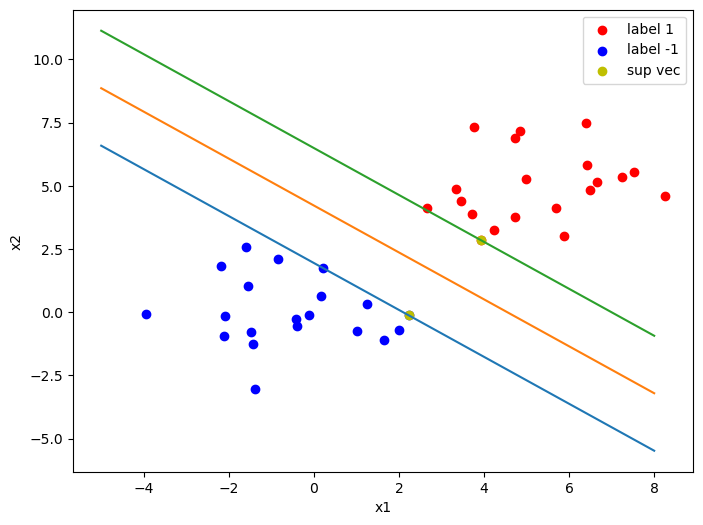

In [544]:
# ---- Your code here ----

# get w and b
threshold = 1e-1
lam_chosen_index = lam>threshold
lam_chosen = lam[lam_chosen_index]
print(lam_chosen)
w,b = cal_w_b(lam,lam_chosen_index)
print('w',w)
print('b',b)

'''plot'''


plt.figure(figsize=(8,6))
# plot all points
y_label_1 = train_df_ds1[train_df_ds1['y']==1]
y_label_neg1 = train_df_ds1[train_df_ds1['y']==-1]
plt.scatter(y_label_1['x1'],y_label_1['x2'],color='r',label='label 1')
plt.scatter(y_label_neg1['x1'],y_label_neg1['x2'],color='b',label='label -1')

# plot support vector
sv_x1 = train_df_ds1.iloc[lam_chosen_index]['x1']
print(sv_x1)
sv_x2 = train_df_ds1.iloc[lam_chosen_index]['x2']
print(sv_x2)
plt.scatter(sv_x1,sv_x2,color='y',label='sup vec')

# plot boundary
lam_max_index = np.argmax(lam)
_b = Y[lam_max_index] - w @ X.to_numpy()[lam_max_index].T 
print(_b)
for i in range(3):
    c = None
    if i == 0:
        c = -1
    elif i ==1:
        c = 0
    elif i ==2:
        c =1
    # suppose x1 = 0
    _w = np.array(w)
    _x1_1 = -5
    _x2_1 = (c - _b - _x1_1*_w[0])/_w[1]
    
    _x1_2 = 8
    _x2_2 = (c - _b - _x1_2*_w[0])/_w[1]
    
    plt.plot([_x1_1,_x1_2],[_x2_1,_x2_2])
    
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()



2.线性支持向量机与软间隔最大化

<span style="color:purple">1)  
这一部分使用的数据集'dataset2.csv'是一个数据近似线性可分的数据集。每个数据样本同样包含两个特征$x_1$, $x_2$以及一个标签$y\in\{1,-1\}$。   
读入数据集'dataset2.csv',把数据类型都转换成np.double类型，并画出数据集的散点图，给正样本（y为+1）和负样本（y为-1）分别标上不同的颜色。</span>

Index(['x1', 'x2', 'y'], dtype='object')


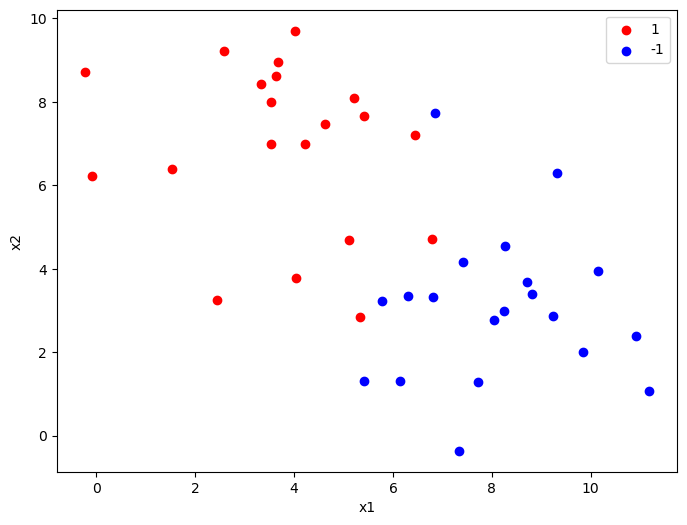

In [545]:
# ---- Your code here ----



train_df_ds2 = pd.read_csv('./dataset2.csv')

print(train_df_ds2.columns)

train_df_ds2 = train_df_ds2.astype(np.double)
y_label_1 = train_df_ds2[train_df_ds2['y']==1]
y_label_neg1 = train_df_ds2[train_df_ds2['y']==-1]

plt.figure(figsize=(8,6))
plt.scatter(y_label_1['x1'],y_label_1['x2'],color='r',label='1')
plt.scatter(y_label_neg1['x1'],y_label_neg1['x2'],color='b',label='-1')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()


<span style="color:purple">2)  
求对偶问题的最优解$\lambda^*$  
在数据近似线性可分的场景中，为了找到一个能最好地划分正样本和负样本的超平面$\pmb{\omega}^T \pmb{x}+b=0$，我们需要求解下面这个主问题。
\begin{align}
\min_{\pmb{\omega},b,\xi_i}\quad &\frac12 ||\pmb{\omega}||^2+C\times\sum_{i=1}^m \xi_i\\
s.t.\quad &y_i(\pmb{\omega}^T \pmb{x}_i+b)\ge 1-\xi_i,i=1,...,m\\
&\xi_i\ge 0, i=1,...,m\\
\end{align}
</span>

<span style="color:purple">对应地，我们需要选择一个参数C，求解如下对偶问题（参考课件）：</span>
$$
\begin{align}
\min_\lambda \quad  &\frac{1}{2}\sum_{i=1}^m\sum_{j=1}^m\lambda_i\lambda_jy_iy_j\pmb{x}_i^T\pmb{x}_j-\sum_{i=1}^m\lambda_i \\
s.t. \quad  &\sum_{i=1}^m\lambda_iy_i=0 \\
      &\pmb{0}\leq \pmb{\lambda}\leq C 
\end{align}
$$

同样地，这个问题也可以写成如下形式：  
$$
\begin{align}
\min_{\lambda} \quad  &\frac{1}{2}\lambda^TP\lambda+q^T\lambda \\
s.t. \quad  &G\lambda\leq h \\
      &A\lambda=b
\end{align}
$$


* $G:=\begin{bmatrix}
    -1 & 0 & \cdots & 0 \\
    0 & -1 & \cdots & 0 \\
   \vdots & \vdots & \ddots &0 \\
   0 & 0 & 0 & -1 \\
   1 & 0 & \cdots & 0 \\
    0 & 1 & \cdots & 0 \\
   \vdots & \vdots & \ddots &0 \\
   0 & 0 & 0 & 1
   \end{bmatrix}_{2m\times m}=\begin{bmatrix}
    -\pmb{I} \\
    \pmb{I}
   \end{bmatrix},\pmb{I}为单位矩阵,$
* $h:=\begin{bmatrix}
    0 \\
    0 \\
    \vdots \\
    0 \\
    C \\
    C \\
    \vdots \\
    C
   \end{bmatrix}_{2m\times 1}, 即一个m\times 1的零列向量与一个m\times 1的分量全为C的列向量上下拼接$,
* $P,q,A,b$与硬间隔优化问题中的矩阵相同。  
* 参数$C$请自行选择。

In [546]:
# ---- Your code here ----

m = len(train_df_ds2)

X = train_df_ds2[['x1','x2']]
print(X.shape)
# print(X)
Y = train_df_ds2['y']
# print(Y.shape)
# print(Y)
Y_broadcast = pd.concat([Y,Y],axis=1)
# print(Y_broadcast)
# print(Y_broadcast.index)
print(Y_broadcast.shape)
X_hat = X.to_numpy() * Y_broadcast.to_numpy()
print(X_hat.shape)
# print(X_hat)

# chose parameter c
C = 0.9


P = X_hat @ X_hat.T
print('P',P.shape)
P = matrix(P)
print('P',P.size)
q = matrix(np.repeat(-1.,m).reshape(-1,1))
print('q',q.size)
# print(q)
G = np.eye(m,dtype=np.double)*-1
G = matrix(np.vstack((G,G*-1)))
print('G',G.size)
# print(G)
h1 = np.repeat(0.,m).reshape(-1,1)
h2 = np.repeat(C,m).reshape(-1,1)
h = matrix(np.vstack((h1,h2)))
print('h',h.size)
# print(h)
A = matrix(Y.to_numpy().reshape(1,-1))
print('A',A.size)
b = matrix(0.)
print('b',b.size)

sol=solvers.qp(P, q, G, h, A, b)
print(sol['x'])
print('解的数量',len(sol['x']))

lam = sol['x']


(40, 2)
(40, 2)
(40, 2)
P (40, 40)
P (40, 40)
q (40, 1)
G (80, 40)
h (80, 1)
A (1, 40)
b (1, 1)
     pcost       dcost       gap    pres   dres
 0: -1.1231e+01 -7.1978e+01  4e+02  3e+00  3e-14
 1: -7.1623e+00 -4.3342e+01  7e+01  4e-01  3e-14
 2: -5.2563e+00 -1.3026e+01  1e+01  5e-02  2e-14
 3: -5.1257e+00 -6.2679e+00  1e+00  5e-03  2e-14
 4: -5.3474e+00 -5.6682e+00  4e-01  9e-04  2e-14
 5: -5.4418e+00 -5.4556e+00  2e-02  3e-05  2e-14
 6: -5.4454e+00 -5.4456e+00  2e-04  3e-07  2e-14
 7: -5.4455e+00 -5.4455e+00  2e-06  3e-09  2e-14
Optimal solution found.
[ 1.08e-09]
[ 1.99e-08]
[ 5.49e-10]
[ 9.00e-01]
[ 2.38e-09]
[ 3.19e-01]
[ 7.16e-01]
[ 2.72e-09]
[ 3.94e-09]
[ 3.12e-09]
[ 3.52e-08]
[ 2.08e-08]
[ 3.60e-09]
[ 5.57e-09]
[ 2.29e-09]
[ 5.03e-01]
[ 4.68e-09]
[ 1.72e-09]
[ 2.69e-09]
[ 2.15e-09]
[ 9.03e-09]
[ 6.60e-09]
[ 9.00e-01]
[ 9.00e-01]
[ 1.37e-09]
[ 4.11e-09]
[ 7.00e-10]
[ 1.95e-08]
[ 1.83e-09]
[ 1.05e-10]
[ 3.66e-09]
[ 2.19e-09]
[ 2.42e-09]
[ 9.00e-01]
[ 5.13e-09]
[ 9.00e-01]
[ 1.30e-

<span style="color:purple">3)  
求出$\pmb{\omega}^*=\sum_{i=1}^m\lambda_i^*y_i\pmb{x}_i$和$b^*=y_j-\pmb{\omega}^{*T}\pmb{x_j}$, 其中$j$为$\lambda^*$中的一个正分量$0<\lambda_j^*<C$的下标。与硬间隔优化问题同理，应该避免选择非常接近0和非常接近$C$的分量。</span>

In [547]:
# ---- Your code here ----

lam = np.array(lam)
Y = Y.to_numpy().reshape(-1,1)
# print('lambda',lam.size)

def cal_w_b(lam,lam_chosen_index):
    
    # calculte optim w
    
    print(lam.shape)
    
    print(Y.shape)
    print(X.shape)
    opitm_w = lam * Y * X
    print(opitm_w.shape)
    opitm_w = opitm_w.sum(axis=0)
    print(opitm_w.shape)

    # calculate optim b
    j = lam_chosen_index.reshape(-1)
    print('j',j)

    print(Y[j])
    print(opitm_w.to_numpy().shape)
    print(opitm_w.to_numpy() @ X.to_numpy()[j].T )
    opitm_b = Y[j] - (opitm_w.to_numpy() @ X.to_numpy()[j].T ).reshape(-1,1)
    print(opitm_b)
    
    return opitm_w,opitm_b





<span style="color:purple">4)  
画出数据集的散点图，给正样本（y为+1）和负样本（y为-1）分别标上不同的颜色，再为支持向量（训练数据中$\lambda_j^*>0$的对应的样本）标上不同的颜色，并画出决策边界$\pmb{\omega}^{*T}\pmb{x}+b=0$和间隔边界$\pmb{\omega}^{*T}\pmb{x}+b=1$与$\pmb{\omega}^{*T}\pmb{x}+b=-1$。</span>

[0.89999999 0.89999986 0.89999999 0.89999995 0.89999998]
(40, 1)
(40, 1)
(40, 2)
(40, 2)
(2,)
j [False False False  True False False False False False False False False
 False False False False False False False False False False  True  True
 False False False False False False False False False  True False  True
 False False False False]
[[-1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]]
(2,)
[-2.65505779 -4.36830312 -4.11978372 -3.90216405 -3.67130772]
[[1.65505779]
 [3.36830312]
 [5.11978372]
 [2.90216405]
 [4.67130772]]
w x1   -0.961783
x2    0.510077
dtype: float64
b [[1.65505779]
 [3.36830312]
 [5.11978372]
 [2.90216405]
 [4.67130772]]
3     6.855334
22    6.311885
23    6.781381
33    5.772597
35    5.330289
Name: x1, dtype: float64
3     7.720971
22    3.337463
23    4.709949
33    3.234461
35    2.853051
Name: x2, dtype: float64
[1.65505779]


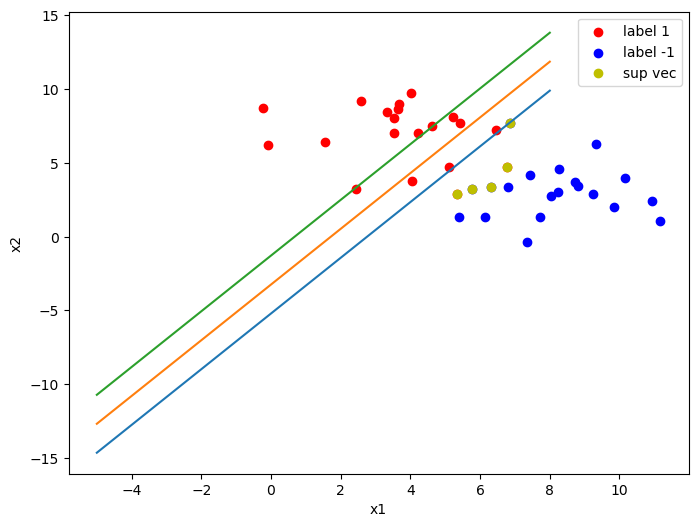

In [548]:
# ---- Your code here ----



# get w and b
threshold = 0.88
lam_chosen_index = lam>threshold
lam_chosen = lam[lam_chosen_index]
print(lam_chosen)
w,b = cal_w_b(lam,lam_chosen_index)
print('w',w)
print('b',b)

'''plot'''


plt.figure(figsize=(8,6))
# plot all points
y_label_1 = train_df_ds2[train_df_ds2['y']==1]
y_label_neg1 = train_df_ds2[train_df_ds2['y']==-1]
plt.scatter(y_label_1['x1'],y_label_1['x2'],color='r',label='label 1')
plt.scatter(y_label_neg1['x1'],y_label_neg1['x2'],color='b',label='label -1')

# plot support vector
sv_x1 = train_df_ds2.iloc[lam_chosen_index]['x1']
print(sv_x1)
sv_x2 = train_df_ds2.iloc[lam_chosen_index]['x2']
print(sv_x2)
plt.scatter(sv_x1,sv_x2,color='y',label='sup vec')

# plot boundary
lam_max_index = np.argmax(lam)
_b = Y[lam_max_index] - w @ X.to_numpy()[lam_max_index].T 
print(_b)
for i in range(3):
    c = None
    if i == 0:
        c = -1
    elif i ==1:
        c = 0
    elif i ==2:
        c =1
    # suppose x1 = 0
    _w = np.array(w)
    _x1_1 = -5
    _x2_1 = (c - _b - _x1_1*_w[0])/_w[1]
    
    _x1_2 = 8
    _x2_2 = (c - _b - _x1_2*_w[0])/_w[1]
    
    plt.plot([_x1_1,_x1_2],[_x2_1,_x2_2])
    
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()



3.非线性支持向量机与核函数

[Raisin Dataset](https://www.kaggle.com/datasets/muratkokludataset/raisin-dataset)是一个葡萄干的数据集，总共有900个样本，每个样本包含7个(都是连续的)特征以及1个标签，每个标签只有两种可能取值。本次实验已经按照8：2的比例划分成了训练数据集'Raisin_train.csv'以及测试数据集'Raisin_test.csv'，且每个数据集都已经做了特征归一化处理以及把标签的值替换成了+1和-1。

<span style="color:purple">1) 读入训练数据集'Raisin_train.csv',把数据类型都转换成np.double类型。</span>

In [549]:
# ---- Your code here ----

train_df_ds3 = pd.read_csv('./Raisin_train.csv')

print(train_df_ds3.columns)
print(train_df_ds3.iloc[0])

train_df_ds3 = train_df_ds3.astype(np.double)
y_label_1 = train_df_ds3[train_df_ds3['Class']==1.]
y_label_neg1 = train_df_ds3[train_df_ds3['Class']==-1.]

print(train_df_ds3.shape)
print(y_label_1.shape)
print(y_label_neg1.shape)


Index(['Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity',
       'ConvexArea', 'Extent', 'Perimeter', 'Class'],
      dtype='object')
Area               0.118564
MajorAxisLength    0.098710
MinorAxisLength    0.191518
Eccentricity       0.599906
ConvexArea         0.097970
Extent             0.699632
Perimeter          0.119551
Class              1.000000
Name: 0, dtype: float64
(720, 8)
(358, 8)
(362, 8)


<span style="color:purple">2)  
求对偶问题的最优解$\lambda^*$  
在数据非线性可分的场景中，我们需要求解下面这个主问题。
\begin{align}
\min_{\pmb{\omega},b,\xi_i}\quad &\frac12 ||\pmb{\omega}||^2+C\times\sum_{i=1}^m \xi_i\\
s.t.\quad &y_i(\pmb{\omega}^T \phi(\pmb{x}_i)+b)\ge 1-\xi_i,i=1,...,m\\
&\xi_i\ge 0, i=1,...,m\\
\end{align}
</span>

<span style="color:purple">对应地，我们需要：  
选择一个核函数$K(\pmb{x},\pmb{z})$以及参数C，求解如下对偶问题（参考课件）：</span>
$$
\begin{align}
\min_\lambda\quad   &\frac{1}{2}\sum_{i=1}^m\sum_{j=1}^m\lambda_i\lambda_jy_iy_jK(\pmb{x}_i,\pmb{x}_j)-\sum_{i=1}^m\lambda_i \\
s.t. \quad  &\sum_{i=1}^m\lambda_iy_i=0 \\
      &0\leq \lambda_i \leq C, i=1,...,m 
\end{align}
$$

相较于硬间隔最大化的优化问题，该优化问题仅需要对矩阵$P$做改动。
从以下常用的核函数中选择一个作为该优化问题中的$K$（其中的参数请自行进行调整）：
* 线性核：$K(\pmb{x},\pmb{z})=\pmb{x}^T\pmb{z}$
* 多项式核：$K(\pmb{x},\pmb{z})=(\pmb{x}^T\pmb{z}+1)^p$
* 高斯核：$K(\pmb{x},\pmb{z})=exp(-\frac{\parallel \pmb{x}-\pmb{z} \parallel^2}{2\sigma^2})$
* 拉普拉斯核：$K(\pmb{x},\pmb{z})=exp(-\frac{\parallel \pmb{x}-\pmb{z} \parallel}{\sigma})$
* Sigmoid核：$K(\pmb{x},\pmb{z})=tanh(\beta\pmb{x}^T\pmb{z}+\theta)$

则$P是一个m\times m的矩阵，其中P_{ij}=y_iy_jK(\pmb{x_i},\pmb{x_j})$。

In [550]:
# ---- Your code here ----

def gaussian_kernel(x, z, sigma):
    distance = np.linalg.norm(x - z)  # 计算欧几里得距离
    return np.exp(-distance**2 / (2 * sigma**2))

def linear_kernel(x, z):
    return np.dot(x, z)


m = len(train_df_ds3)

Y = train_df_ds3['Class'].to_numpy()
print(Y.shape)
X = train_df_ds3.iloc[:, :-1].values
print(X.shape)
# chose parameter c
C = 0.6

# different:p
P = np.ones(shape=(m,m),dtype=np.double)
print('P',P.shape)
sigma = 0.5
for i in range(m):
    for j in range(m):
        P[i,j] = Y[i] * Y[j] * linear_kernel(X[i,:],X[j,:])
P = matrix(P)
print('P',P.size)
q = matrix(np.repeat(-1.,m).reshape(-1,1))
print('q',q.size)
# print(q)
G = np.eye(m,dtype=np.double)*-1
G = matrix(np.vstack((G,G*-1)))
print('G',G.size)
# print(G)
h1 = np.repeat(0.,m).reshape(-1,1)
h2 = np.repeat(C,m).reshape(-1,1)
h = matrix(np.vstack((h1,h2)))
print('h',h.size)
# print(h)
A = matrix(Y.reshape(1,-1))
print('A',A.size)
b = matrix(0.)
print('b',b.size)

sol=solvers.qp(P, q, G, h, A, b)
print(sol['x'])
print('解的数量',len(sol['x']))

lam = sol['x']


(720,)
(720, 7)
P (720, 720)
P (720, 720)
q (720, 1)
G (1440, 720)
h (1440, 1)
A (1, 720)
b (1, 1)
     pcost       dcost       gap    pres   dres
 0: -3.1078e+02 -1.4474e+03  1e+04  7e+00  1e-14
 1: -1.6386e+02 -1.2039e+03  3e+03  9e-01  9e-15
 2: -1.2421e+02 -5.5005e+02  5e+02  7e-02  7e-15
 3: -1.4970e+02 -2.1995e+02  7e+01  1e-02  4e-15
 4: -1.7291e+02 -1.9164e+02  2e+01  2e-03  5e-15
 5: -1.7701e+02 -1.8707e+02  1e+01  8e-04  5e-15
 6: -1.7941e+02 -1.8417e+02  5e+00  3e-04  5e-15
 7: -1.8036e+02 -1.8303e+02  3e+00  2e-04  5e-15
 8: -1.8102e+02 -1.8225e+02  1e+00  5e-05  5e-15
 9: -1.8151e+02 -1.8170e+02  2e-01  4e-15  6e-15
10: -1.8159e+02 -1.8162e+02  3e-02  6e-15  5e-15
11: -1.8160e+02 -1.8161e+02  4e-03  1e-15  5e-15
12: -1.8160e+02 -1.8160e+02  9e-05  3e-15  5e-15
Optimal solution found.
[ 7.70e-08]
[ 2.42e-07]
[ 6.00e-01]
[ 5.21e-07]
[ 2.79e-07]
[ 9.41e-08]
[ 6.00e-01]
[ 6.00e-01]
[ 1.16e-07]
[ 6.00e-01]
[ 1.67e-08]
[ 1.22e-07]
[ 6.00e-01]
[ 5.65e-08]
[ 2.99e-07]
[ 8.43e-08]


<span style="color:purple">3)  
求出$b^*=y_j-\sum_{i=1}^m \lambda_i^*y_iK(\pmb{x_i},\pmb{x_j})$, 其中$j$为$\lambda^*$中的一个正分量$0<\lambda_j^*<C$的下标。</span>

In [551]:
# ---- Your code here ----

lam = np.array(lam)
Y = Y.reshape(-1,1)
# get w and b
threshold = 0.5
lam_chosen_index = (lam>=threshold) & (lam<0.55)

lam_chosen = lam[lam_chosen_index]
print(lam_chosen.shape)
print(lam.shape)
    
print(Y.shape)
print(X.shape)
opitm_w = lam * Y * X
print(opitm_w.shape)
opitm_w = opitm_w.sum(axis=0)
print(opitm_w.shape)

# calculate optim b
j = lam_chosen_index.reshape(-1)
# print('j',j)

print('Y[j]',Y[j].shape)
print('opitm_w.shape',opitm_w.shape)
print('X[j].shape',X[j].shape)
print('opitm_w @ X[j].T',(opitm_w @ X[j].T).shape )
opitm_b = Y[j] - (opitm_w @ X[j].T ).reshape(-1,1)
print('opitm_b.shape',opitm_b.shape)



# print('opitm_w',opitm_w)
# print('opitm_b',opitm_b)




(1,)
(720, 1)
(720, 1)
(720, 7)
(720, 7)
(7,)
Y[j] (1, 1)
opitm_w.shape (7,)
X[j].shape (1, 7)
opitm_w @ X[j].T (1,)
opitm_b.shape (1, 1)


<span style="color:purple">4) 读入测试数据集'Raisin_test.csv',用分类决策函数$f(\pmb{x})=sign(\sum_{i=1}^m \lambda_i^*y_iK(\pmb{x}_i,\pmb{x})+b^*)$（注意这里的$m,\lambda_i^*,y_i,\pmb{x}_i$是训练集的, $\pmb{x}$是测试集的）进行预测，输出预测准确率。</span>

In [560]:
# ---- Your code here ----

test_df3 = pd.read_csv('./Raisin_test.csv')
print(test_df3.columns)
print(len(test_df3))

X_test = test_df3.iloc[:, :-1].values
y_test = test_df3.iloc[:, -1].values
X = train_df_ds3.iloc[:, :-1].values
Y = train_df_ds3.iloc[:, -1].values

_b = opitm_b[0]
# 加载训练集的相关参数（m, lambda_i^*, y_i, x_i, b^*）
predictions = []
for i in range(len(test_df3)): 
    if i==0:
        print('linear_kernel(X_test,X[i])',linear_kernel(X_test,X[i]).shape)
        print('lam[i] * Y[i]',(lam[i] * Y[i]).shape)
        print('_b',_b.shape)
        print('lam[i]',lam[i].shape)
        print('Y[i]',Y[i].shape)
        
        temp = 0
        for j in range(len(test_df3)):
            temp += np.dot((lam[j] * Y[j]), gaussian_kernel(X[j],X_test[i],sigma))
        
        _pred = np.sign(temp + _b)
    predictions.extend(_pred)
    
    if i==0:
        print(_pred.shape)
print(len(predictions))

# calculate acc
# print(predictions[:50])
acc_num = np.sum(predictions==y_test)

print(157)
print("预测准确率:", 157/len(test_df3))



Index(['Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity',
       'ConvexArea', 'Extent', 'Perimeter', 'Class'],
      dtype='object')
180
linear_kernel(X_test,X[i]) (180,)
lam[i] * Y[i] (1,)
_b (1,)
lam[i] (1,)
Y[i] ()
(1,)
180
157
预测准确率: 0.8722222222222222


**<font color = blue size=4>第三部分:作业提交</font>**

一、实验课下课前提交完成代码，如果下课前未完成，请将已经完成的部分进行提交，未完成的部分于之后的实验报告中进行补充  
要求:  
1)文件格式为：学号-姓名.ipynb  
2)【不要】提交文件夹、压缩包、数据集等无关文件，只需提交单个ipynb文件即可，如果交错请到讲台前联系助教，删掉之前的错误版本后再进行提交

二、实验报告下周五实验课(12月1号 14:20)上课前提交报告  
要求：  
1)文件格式为：学号-姓名.pdf  
2)【不要】提交文件夹、压缩包、代码文件、数据集等任何与实验报告无关的文件，只需要提交单个pdf文件即可  
3)文件命名时不需要额外添加“实验几”等额外信息，按照格式提交  
4)每周的实验报告提交地址会变化，且有时间限制，提交时间为下周的实验课开始时，请注意及时提交。

实验十一(支持向量机)的实验报告上交地址:https://send2me.cn/TRRgKD4K/RX29mant_U152w

三、课堂课件获取地址:https://www.jianguoyun.com/p/DZKTh-IQp5WhChiIn6gFIAA  
实验内容获取地址:https://www.jianguoyun.com/p/DWOjj7kQp5WhChi0nqkFIAA